In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# to integrate the solver to network
class PyhsicalSolverLayer(torch.nn.Module):
    def __init__(self):
        super(PyhsicalSolverLayer, self).__init__()
    
    def forward(self,
                starting_points: torch.Tensor, 
                del_x: torch.Tensor, 
                force_vec: torch.Tensor):
        batch_size = starting_points.size(0) # deal with batch_size > 1
        num_steps = force_vec.size(1)
        traj = torch.zeros((batch_size, num_steps + 1 ,2))
        traj[:, 0,: ] = starting_points # set each of the batches
        for i in range(num_steps):
            traj[:, i + 1, 0] = traj[:, i, 0] + del_x.unsqueeze(0)
            traj[:, i + 1, 1] = traj[:, i, 1] + force_vec[:, i]
        return traj

In [3]:
class DiffPyhsicsModel(torch.nn.Module):
    def __init__(self):
        super(DiffPyhsicsModel, self).__init__()
        self.hidden_layer = torch.nn.Linear(1, 10)
        self.output_layer = torch.nn.Linear(10, 20)
        self.solver_layer = PyhsicalSolverLayer()

    def forward(self,  
                state0: torch.Tensor, 
                steps: int, 
                x_step: torch.Tensor):
        batch_size = state0.size(0)
        force = torch.reshape(state0[:, 1],(batch_size, 1))
        force = self.hidden_layer(force)
        force = torch.relu(force)
        force = self.output_layer(force) # output of network: force vector
        # call physical solver 
        traj = self.solver_layer(state0, x_step, force)
        return traj

In [4]:
class PyhsicalLoss(torch.nn.Module):
    def __init__(self):
        super(PyhsicalLoss, self).__init__()
    
    def potential(self, sequence : torch.Tensor):
        x2y2 = torch.square(sequence) # [x ^ 2, y ^ 2]
        x2y2_sum = torch.sum(x2y2, -1) # [x ^ 2 + y ^ 2]
        x2y2_subs = torch.sub(x2y2_sum, torch.Tensor([1.])) # [x ^ 2 + y ^ 2 -1]
        return torch.square(x2y2_subs)# [(x ^ 2 + y ^ 2 -1) ^ 2]
    
    def forward(self, sequence: torch.Tensor):
        potential_loss = self.potential(sequence)
        return torch.sum(potential_loss)

In [5]:
X_STEP = .1

In [6]:
starting_points = torch.zeros((100,2))
starting_points[:,0] = -1
r1 = -.01
r2 = .01
starting_points[:,1] = torch.rand(100) * (r2 - r1) - r2
starting_points.shape

torch.Size([100, 2])

In [7]:
solver_involved_network = DiffPyhsicsModel()
physical_loss = PyhsicalLoss()
optimizer = torch.optim.Adam(solver_involved_network.parameters(), lr=1e-2)

In [8]:
batch_size = 100 # single batch training 
for i in range(1500):
    for j in range(0, len(starting_points), batch_size):
        optimizer.zero_grad()
        traj_pred = solver_involved_network(starting_points[j:j+batch_size], 20, torch.tensor(X_STEP))
        loss = physical_loss(traj_pred)
        loss.backward()
        optimizer.step()
    if(i + 1) % 100 == 0:        
        print(f"Epoch: {i + 1} loss: {loss}")

Epoch: 100 loss: 1.283417820930481
Epoch: 200 loss: 0.04234529286623001
Epoch: 300 loss: 0.00781572237610817
Epoch: 400 loss: 0.005554910749197006
Epoch: 500 loss: 0.005238089244812727
Epoch: 600 loss: 0.00510201882570982
Epoch: 700 loss: 0.005026465747505426
Epoch: 800 loss: 0.01249097939580679
Epoch: 900 loss: 0.004973959643393755
Epoch: 1000 loss: 0.2247501015663147
Epoch: 1100 loss: 0.004943879786878824
Epoch: 1200 loss: 1.9224402904510498
Epoch: 1300 loss: 0.004988398402929306
Epoch: 1400 loss: 0.06819777190685272
Epoch: 1500 loss: 0.005044334568083286


In [33]:
test_points = torch.zeros((25,2))
test_points[:, 0] = -1
r1 = -.01
r2 = .01
test_points[:, 1] = torch.rand(25) * (r2 - r1) - r2

In [34]:
x_traj = [-1] # same traj for all points
for i in range(20):
    x_traj.append(x_traj[-1] + .1)

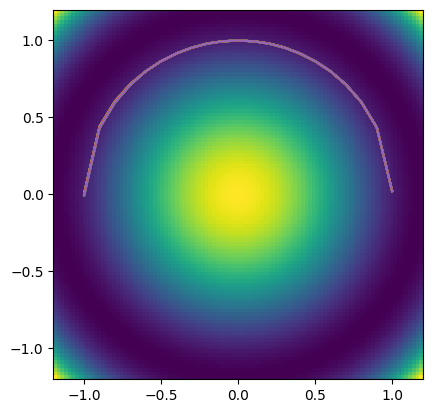

In [99]:
x,y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
z = (x ** 2 + y ** 2  - 1) ** 2
plt.imshow(z, extent = [-1.2, 1.2, -1.2, 1.2])
for i in range(25):
    with torch.no_grad():
        pred_traj = solver_involved_network(test_points[i].unsqueeze(0), 20, torch.tensor(X_STEP))
    plt.plot(pred_traj[:, :, 0][0], pred_traj[:, :, 1][0])